In [3]:
!pip install SimpleITK

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
count = 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/subset0'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count +=1
print(count)

/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw
/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.raw
/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.raw
/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.raw
/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.raw


In [6]:
from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import os
from glob import glob
import pandas as pd

# Disable tqdm if not needed
tqdm = lambda x: x

# Function to create a mask around a nodule
def make_mask(mask, v_center, v_diam, spacing):
    v_diam_z = int(v_diam / spacing[2] + 1)
    v_diam_y = int(v_diam / spacing[1] + 1)
    v_diam_x = int(v_diam / spacing[0] + 1)

    v_diam_z = int(np.rint(v_diam_z / 2))
    v_diam_y = int(np.rint(v_diam_y / 2))
    v_diam_x = int(np.rint(v_diam_x / 2))

    z_min = max(int(v_center[0] - v_diam_z), 0)
    z_max = min(int(v_center[0] + v_diam_z + 1), mask.shape[0])
    x_min = max(int(v_center[1] - v_diam_x), 0)
    x_max = min(int(v_center[1] + v_diam_x + 1), mask.shape[1])
    y_min = max(int(v_center[2] - v_diam_y), 0)
    y_max = min(int(v_center[2] + v_diam_y + 1), mask.shape[2])

    mask[z_min:z_max, x_min:x_max, y_min:y_max] = 1.0
    # Output nodule pixel size for debugging
    print(f"Mask region (z, x, y): {(z_max - z_min, x_max - x_min, y_max - y_min)}")

# Helper function to find the full file path based on series UID
def get_filename(file_list, case):
    for f in file_list:
        if case == os.path.basename(f):
            return f
    return None

# Main processing loop
def main():
    # Define input and output paths
    input_path = '/content/drive/MyDrive/subset0'
    output_path = '/content/Subset_0'

    # Create output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        print(f"Created output directory: {output_path}")

    # Get list of all .mhd files in the input directory
    file_list = glob(os.path.join(input_path, "*.mhd"))
    if not file_list:
        print(f"No .mhd files found in {input_path}. Exiting.")
        return

    # Remove the '.mhd' extension for mapping purposes
    file_list_path = [os.path.splitext(f)[0] for f in file_list]

    # Load nodules annotations
    annotations_path = '/content/annotations (1).csv'
    if not os.path.exists(annotations_path):
        print(f"Annotations file not found at {annotations_path}. Exiting.")
        return

    df_node = pd.read_csv(annotations_path)
    # Map seriesuid to full file paths
    df_node["file"] = df_node["seriesuid"].apply(lambda uid: get_filename(file_list_path, uid))
    df_node = df_node.dropna(subset=["file"])  # Drop rows where file was not found

    print(f"Total annotations after mapping: {len(df_node)}")

    # Iterate over each image file
    for fcount, img_file_path in enumerate(tqdm(file_list_path)):
        mini_df = df_node[df_node["file"] == img_file_path]

        img_file_full = img_file_path + ".mhd"
        try:
            itk_img = sitk.ReadImage(img_file_full)
        except Exception as e:
            print(f"Error reading image file {img_file_full}: {e}")
            continue

        img_array = sitk.GetArrayFromImage(itk_img)
        num_z, height, width = img_array.shape
        origin = np.array(itk_img.GetOrigin())
        spacing = np.array(itk_img.GetSpacing())

        # Initialize mask
        mask_itk = np.zeros((num_z, height, width), dtype=np.float32)

        if not mini_df.empty:
            for _, row in mini_df.iterrows():
                node_x = row["coordX"]
                node_y = row["coordY"]
                node_z = row["coordZ"]
                diam = row["diameter_mm"]

                center_world = np.array([node_x, node_y, node_z])
                # Convert world coordinates to voxel indices
                v_center = np.rint((center_world - origin) / spacing).astype(int)
                # Reorder to z, y, x
                v_center = [v_center[2], v_center[1], v_center[0]]

                make_mask(mask_itk, v_center, diam, spacing)
            print(f"Processed {len(mini_df)} nodules for image {os.path.basename(img_file_full)}")
        else:
            print(f"No nodules found for image {os.path.basename(img_file_full)}")

        # Prepare mask for saving
        mask_itk = np.clip(mask_itk * 255, 0, 255).astype(np.uint8)
        sitk_maskimg = sitk.GetImageFromArray(mask_itk)
        sitk_maskimg.SetSpacing(itk_img.GetSpacing())
        sitk_maskimg.SetOrigin(itk_img.GetOrigin())

        # Construct output file name
        sub_img_file = os.path.basename(img_file_path)
        output_mask_file = os.path.join(output_path, f"{sub_img_file}_segmentation.mhd")

        try:
            sitk.WriteImage(sitk_maskimg, output_mask_file)
            print(f"Saved mask to {output_mask_file}")
        except Exception as e:
            print(f"Failed to save mask {output_mask_file}: {e}")
if __name__ == "__main__":
    main()

Created output directory: /content/Subset_0
Total annotations after mapping: 112
No nodules found for image 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
Saved mask to /content/Subset_0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_segmentation.mhd
Mask region (z, x, y): (13, 25, 25)
Mask region (z, x, y): (5, 9, 9)
Processed 2 nodules for image 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
Saved mask to /content/Subset_0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_segmentation.mhd
Mask region (z, x, y): (5, 9, 9)
Processed 1 nodules for image 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
Saved mask to /content/Subset_0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_segmentation.mhd
Mask region (z, x, y): (9, 9, 9)
Processed 1 nodules for image 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
Saved mask to /content/Subset_0/1.3.6.1.4.1.14519

In [7]:
import pandas as pd
an_df = pd.read_csv('/content/annotations (1).csv')


In [8]:
an_df['seriesuid'][0]

'1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860'

In [9]:
# prompt: find weather file a is in my drive or not

import os
count_1 = 0
count_2 = 0
def file_exists_in_drive(file_path):
  """Checks if a file exists in Google Drive.

  Args:
    file_path: The path to the file in Google Drive.

  Returns:
    True if the file exists, False otherwise.
  """
  try:
    return os.path.exists(file_path)
  except Exception as e:
    print(f"Error checking file existence: {e}")
    return False

# Example usage:

for i in range(len(an_df['seriesuid'])):
  file_a_path = '/content/drive/MyDrive/subset0/' + an_df['seriesuid'][i] + '.mhd'
  if file_exists_in_drive(file_a_path):
    print(f"File '{file_a_path}' exists in your Google Drive.")
    count_1 += 1
  else:
    print(f"File '{file_a_path}' does not exist in your Google Drive.")
    count_2 += 1

print("No path exists:",count_2)
print("Path exists:",count_1)

File '/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd' does not exist in your Google Drive.
File '/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd' does not exist in your Google Drive.
File '/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd' does not exist in your Google Drive.
File '/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd' does not exist in your Google Drive.
File '/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd' does not exist in your Google Drive.
File '/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd' does not exist in your Google Drive.
File '/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd' does not exist in your Google

In [10]:
input_path = '/content/drive/MyDrive/subset0'
annotation_df = pd.read_csv('/content/annotations (1).csv')
file_list = glob(os.path.join(input_path, "*.mhd"))
file_list_path = [os.path.splitext(f)[0] for f in file_list]
df_node = pd.read_csv('/content/annotations (1).csv')
# Map seriesuid to full file paths
df_node["file"] = df_node["seriesuid"].apply(lambda uid: get_filename(file_list_path, uid))
df_node = df_node.dropna(subset=["file"])

In [11]:
len(file_list)

89

In [12]:
!pip install tqdm # Install the tqdm module
from tqdm import tqdm

In [13]:

def get_cube_from_img(img3d, x, y, z, v_diam, spacing):
    v_diam_z = int(v_diam / spacing[2] + 1)
    v_diam_y = int(v_diam / spacing[1] + 1)
    v_diam_x = int(v_diam / spacing[0] + 1)

    v_diam_z = int(np.rint(v_diam_z / 2))
    v_diam_y = int(np.rint(v_diam_y / 2))
    v_diam_x = int(np.rint(v_diam_x / 2))

    # Define block size as the maximum of v_diam_x, v_diam_y, and v_diam_z
    block_size = max(v_diam_x, v_diam_y, v_diam_z)
    # Get the center coordinates (z, y, x) in world coordinates
    center_world = np.array([x, y, z])

    # Convert world coordinates to voxel indices
    origin = np.array(itk_img.GetOrigin())
    v_center = np.rint((center_world - origin) / spacing).astype(int)
    center_z, center_y, center_x = v_center[2], v_center[1], v_center[0]

    # Calculate the starting and ending points for each dimension (z, y, x)
    start_x = max(int(center_x - block_size), 0)
    start_y = max(int(center_y - block_size), 0)
    start_z = max(int(center_z - block_size), 0)

    end_x = min(start_x + block_size * 2, img3d.shape[2])
    end_y = min(start_y + block_size * 2, img3d.shape[1])
    end_z = min(start_z + block_size * 2, img3d.shape[0])

    # Adjust start points if the block exceeds the boundaries
    if end_x - start_x < block_size * 2:
        start_x = max(end_x - block_size * 2, 0)
    if end_y - start_y < block_size * 2:
        start_y = max(end_y - block_size * 2, 0)
    if end_z - start_z < block_size * 2:
        start_z = max(end_z - block_size * 2, 0)


    # Extract the ROI cube
    roi_img3d = img3d[start_z:end_z, start_y:end_y, start_x:end_x]

    return roi_img3d


In [16]:
# prompt: in above cell save the roi in patches folder with seriesuid.npy format

import os
nodules = []
for i in range(int(len(annotation_df['seriesuid']))):
  file_a_path = '/content/drive/MyDrive/subset0/' + annotation_df['seriesuid'][i] + '.mhd'
  try:
      itk_img = sitk.ReadImage(file_a_path)
  except Exception as e:
      #print(f"Error reading image file {file_a_path}: {e}")
      continue
  # getting coordinates
  x = annotation_df['coordX'][i]
  y = annotation_df['coordY'][i]
  z = annotation_df['coordZ'][i]
  v_diam = annotation_df['diameter_mm'][i]
  img3d = sitk.GetArrayFromImage(itk_img)
  spacing = np.array(itk_img.GetSpacing())
  roi_img3d = get_cube_from_img(img3d, x, y, z, v_diam, spacing)
  # Save the ROI to the patch folder with seriesuid.npy format
  if not os.path.exists('/content/patches_seriesuid_1'):
        os.makedirs('/content/patches_seriesuid_1')
  output_file = os.path.join('/content/patches_seriesuid_1', f"{annotation_df['seriesuid'][i]}.npy")
  nodules.append(annotation_df['seriesuid'][i])
  np.save(output_file, roi_img3d)

In [17]:
# prompt: remove all duplicates from nodules

nodules_unique = list(dict.fromkeys(nodules))
print(f"Total unique id: {len(nodules_unique)}")

Total unique id: 67


In [ ]:

# for i in range(int(len(annotation_df['seriesuid'])/2),len(annotation_df['seriesuid'])):
#   file_a_path = '/content/drive/MyDrive/subset0/' + annotation_df['seriesuid'][i] + '.mhd'
#   try:
#       itk_img = sitk.ReadImage(file_a_path)
#   except Exception as e:
#       #print(f"Error reading image file {file_a_path}: {e}")
#       continue
#   # getting coordinates
#   x = annotation_df['coordX'][i]
#   y = annotation_df['coordY'][i]
#   z = annotation_df['coordZ'][i]
#   v_diam = annotation_df['diameter_mm'][i]
#   img3d = sitk.GetArrayFromImage(itk_img)
#   spacing = np.array(itk_img.GetSpacing())
#   roi_img3d = get_cube_from_img(img3d, x, y, z, v_diam, spacing)
#   rois.append(roi_img3d)

In [18]:
itk_img = sitk.ReadImage('/content/drive/MyDrive/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd')
img3d = sitk.GetArrayFromImage(itk_img)
spacing = np.array(itk_img.GetSpacing())
x = annotation_df['coordX'][1180]
y = annotation_df['coordY'][1180]
z = annotation_df['coordZ'][1180]
v_diam = annotation_df['diameter_mm'][1180]

roi_img3d = get_cube_from_img(img3d, x, y, z, v_diam, spacing)

In [19]:
roi_img3d.shape

(12, 12, 12)

In [20]:
v_diam/spacing[0]

11.008609583155364

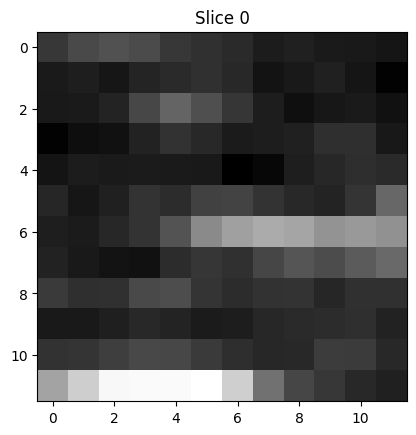

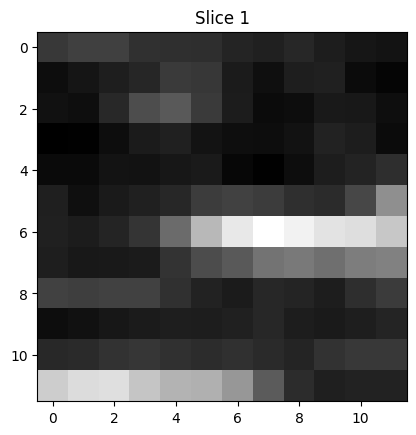

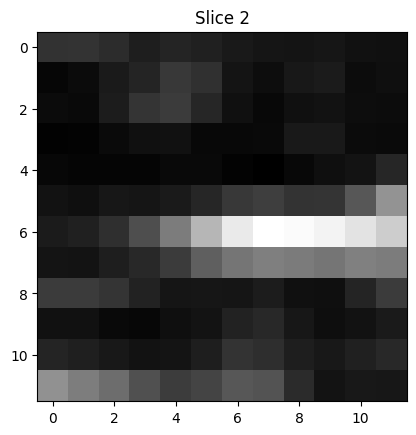

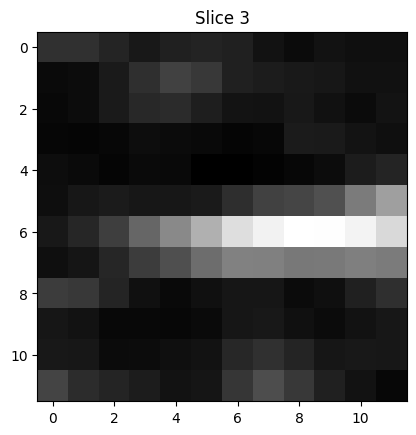

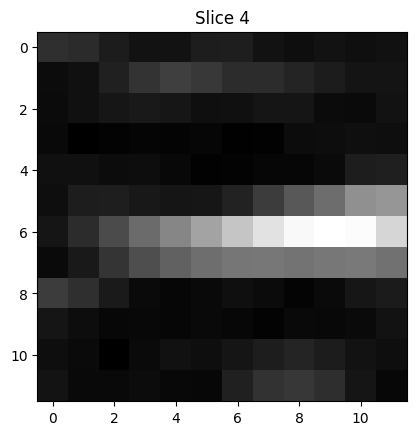

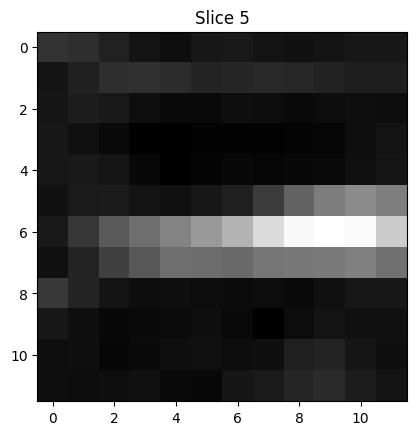

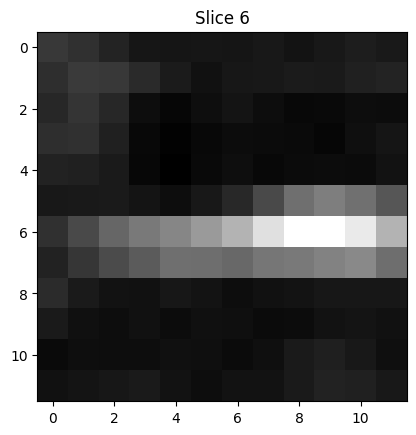

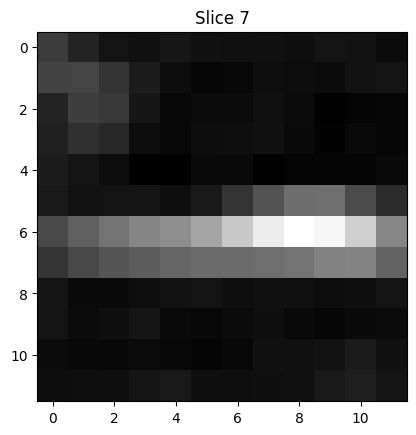

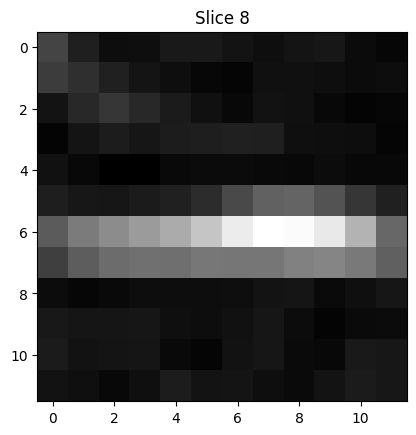

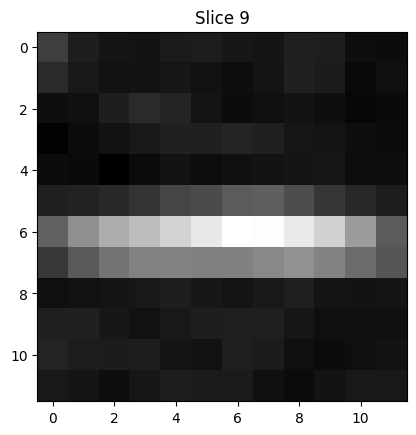

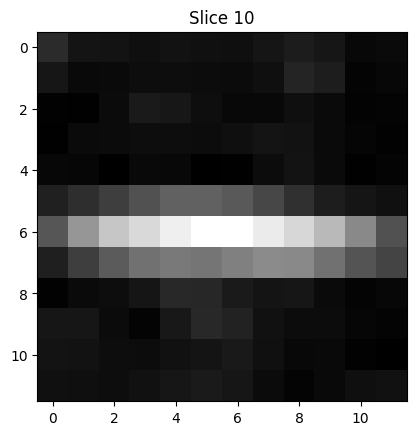

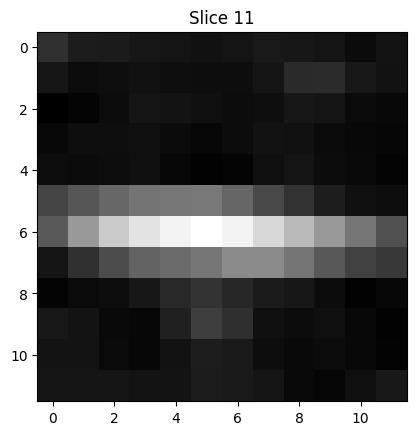

In [21]:
# prompt: plot all slices of roi_img3d

import matplotlib.pyplot as plt

for i in range(roi_img3d.shape[2]):
  plt.imshow(roi_img3d[:, :, i], cmap='gray')
  plt.title(f'Slice {i}')
  plt.show()

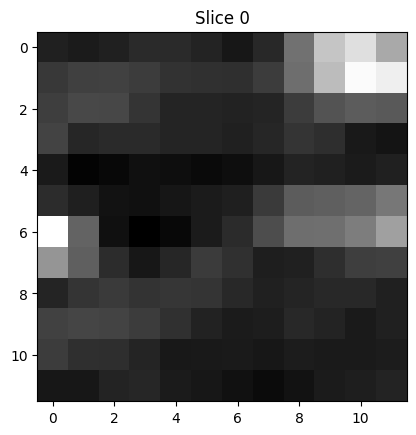

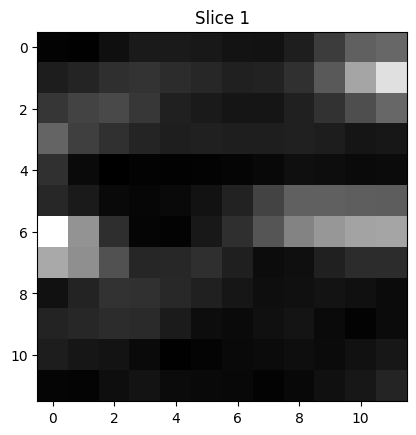

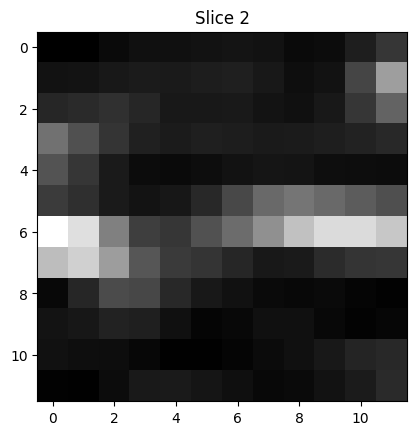

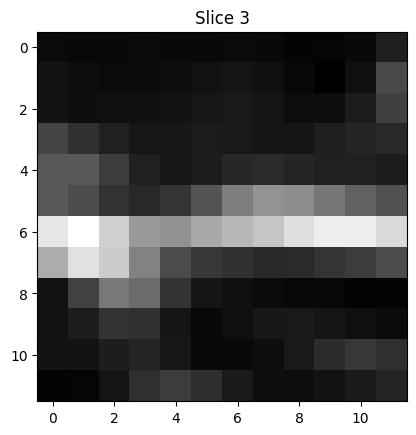

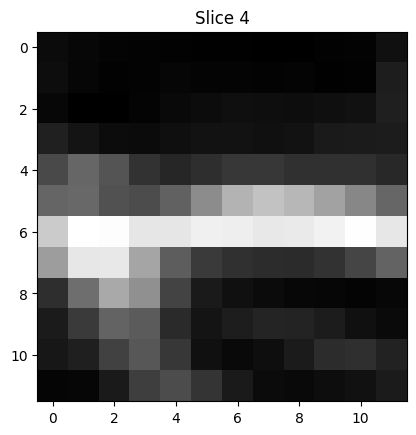

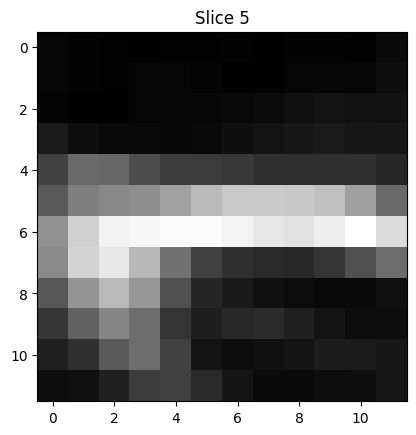

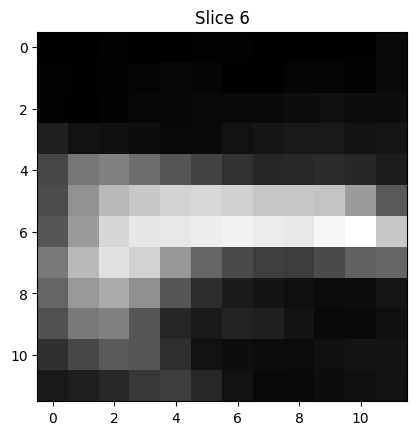

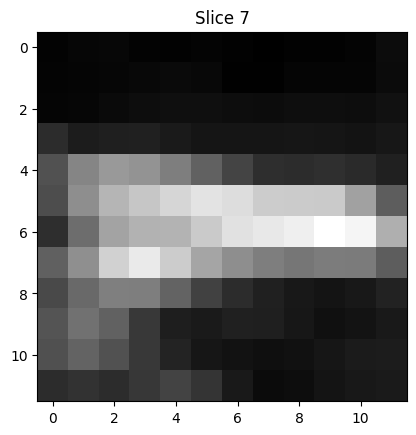

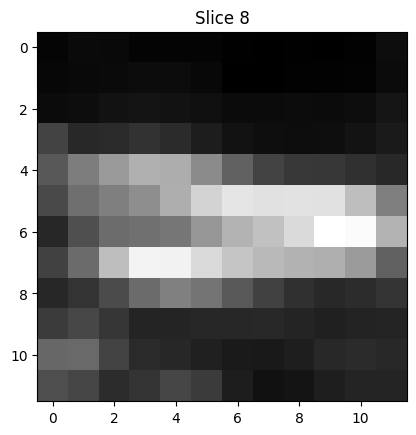

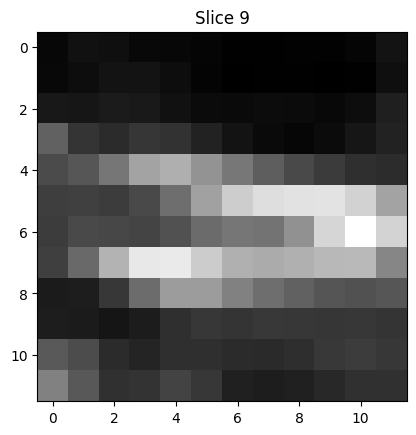

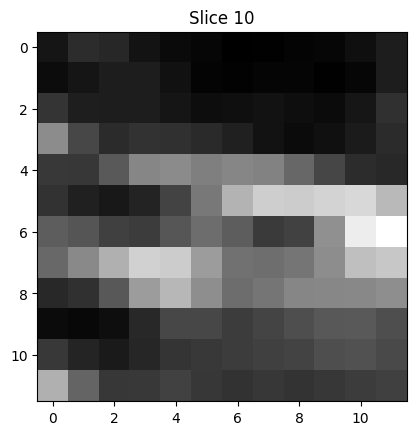

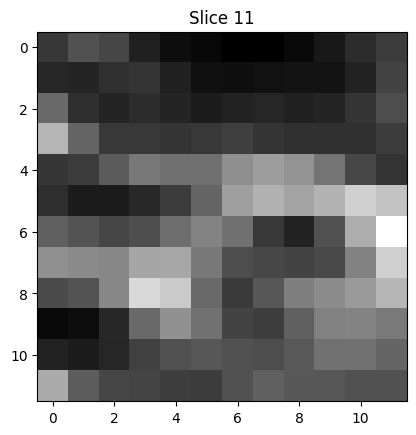

In [22]:
# prompt: plot  a random roi image present in patch folder in content

import random
import matplotlib.pyplot as plt
import os
import numpy as np

patch_folder = '/content/patch'

# Get a list of all ROI files in the patch folder
roi_files = [f for f in os.listdir(patch_folder) if f.endswith('.npy')]

# Select a random ROI file
random_roi_file = random.choice(roi_files)

# Load the random ROI
roi_img3d = np.load(os.path.join(patch_folder, random_roi_file))

# Display slices of the ROI using matplotlib
for i in range(roi_img3d.shape[2]):
  plt.imshow(roi_img3d[:, :, i], cmap='gray')
  plt.title(f'Slice {i}')
  plt.show()

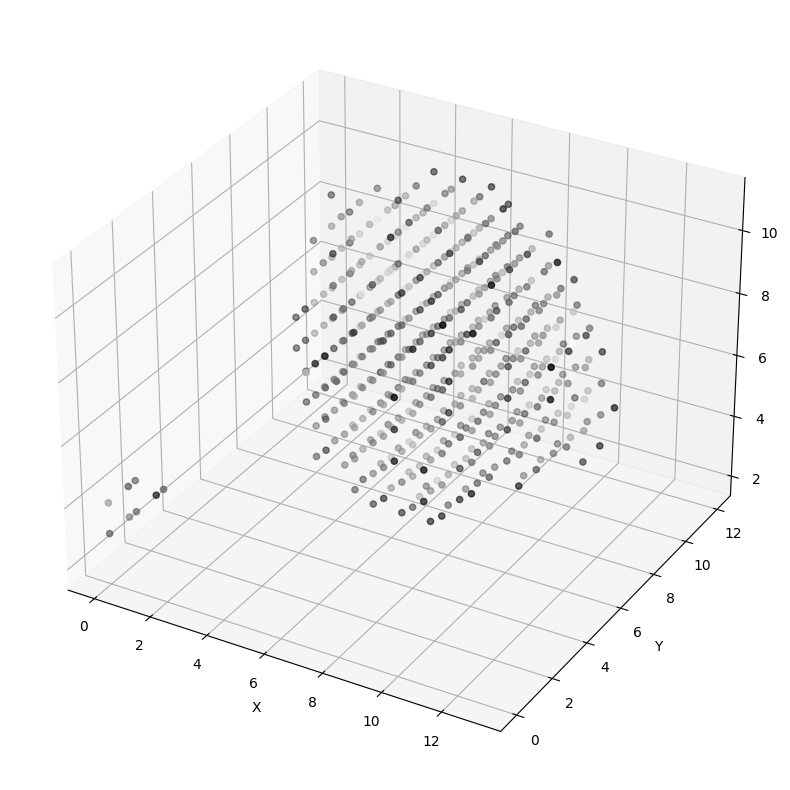

In [29]:


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

import random
import matplotlib.pyplot as plt
import os
import numpy as np

patch_folder = '/content/patch'

# Get a list of all ROI files in the patch folder
roi_files = [f for f in os.listdir(patch_folder) if f.endswith('.npy')]

# Select a random ROI file
random_roi_file = random.choice(roi_files)

# Load the random ROI
roi_img3d = np.load(os.path.join(patch_folder, random_roi_file))

# Display slices of the ROI using matplotlib
# for i in range(roi_img3d.shape[2]):
#   plt.imshow(roi_img3d[:, :, i], cmap='gray')
#   plt.title(f'Slice {i}')
#   plt.show()

# Create a figure and an axes object for 3D plotting
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid of coordinates for the 3D image
x, y, z = np.indices(roi_img3d.shape)

# Plot the 3D image using scatter plot
# You can adjust the threshold to visualize different parts of the image
threshold = -100
ax.scatter(x[roi_img3d > threshold], y[roi_img3d > threshold], z[roi_img3d > threshold],
           c=roi_img3d[roi_img3d > threshold], cmap='gray')

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [30]:
candidates_df = pd.read_csv('/content/candidates.csv')

In [31]:
candidates_df.value_counts(['seriesuid','coordX','coordY','coordZ'])

seriesuid                                                         coordX       coordY       coordZ     
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860  -138.050000  -150.520000  -335.810000    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.307921770358136677021532761235  -27.600000    102.960000  -188.740000    1
                                                                  -22.576324    37.871938   -227.405690    1
                                                                  -22.598533    86.768645   -139.698246    1
                                                                  -23.052793    40.107187   -213.158211    1
                                                                                                          ..
1.3.6.1.4.1.14519.5.2.1.6279.6001.200513183558872708878454294671  -79.891459   -66.135691   -251.829056    1
                                                                  -80.390000    37.160000   -153.570000    1
                                                                               -16.820000   -233.910000    1
                                                                  -81.790000   -3.500000    -181.060000    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335   107.650000   7.800000    -205.100000    1
Name: count, Length: 551065, dtype: int64

In [32]:
len(annotation_df['seriesuid'])

1186

In [33]:


nodules_df = pd.DataFrame({'seriesuid': nodules_unique})
candidates_df_filtered = pd.merge(candidates_df, nodules_df, on='seriesuid', how='inner')
len(candidates_df_filtered)

43002

In [34]:
candidates_df_filtered['class'].value_counts()

,count
class,
0,42880
1,122


In [35]:
candidates_df_filtered.value_counts(['seriesuid'])

,count
seriesuid,
1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492,1094
1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367,1076
1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565,1061
1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005,1019
1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235,999
...,...
1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227,316
1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493,313
1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223,312


In [36]:


import pandas as pd

# Assuming your dataframe is named 'annotation_df'
annotation_df = pd.read_csv('/content/annotations (1).csv')

# Extract the 'diameter_mm' column
diameters = annotation_df['diameter_mm']

# Calculate the 90th percentile of diameters
percentile_90 = np.percentile(diameters, 90)

print(f"The 90th percentile largest diameter is: {percentile_90}")

The 90th percentile largest diameter is: 15.482981935


In [ ]:
# prompt: write same patch extraction code for all entries in candidates_df_filtered

def extract_patch_for_candidate(row):
  """Extracts a patch for a candidate nodule from the corresponding image.

  Args:
    row: A pandas Series representing a row in candidates_df_filtered.

  Returns:
    The extracted patch as a NumPy array, or None if an error occurs.
  """
  try:
    seriesuid = row['seriesuid']
    x = row['coordX']
    y = row['coordY']
    z = row['coordZ']
    diameter = 16

    file_path = os.path.join('/content/drive/MyDrive/subset0', seriesuid + '.mhd')
    itk_img = sitk.ReadImage(file_path)
    img3d = sitk.GetArrayFromImage(itk_img)
    spacing = np.array(itk_img.GetSpacing())

    roi_img3d = get_cube_from_img(img3d, x, y, z, diameter, spacing)

    return roi_img3d

  except Exception as e:
    print(f"Error extracting patch for {seriesuid}: {e}")
    return None

labels = []
# Iterate through the candidates_df_filtered DataFrame and extract patches
for index, row in tqdm(candidates_df_filtered.iterrows(), total=len(candidates_df_filtered)):
  roi_img3d = extract_patch_for_candidate(row)
  labels.append(row['class'])

  if roi_img3d is not None:
    # Save the ROI to the patch folder
    if not os.path.exists('/content/candidate_patches'):
        os.makedirs('/content/candidate_patches')
    output_file = os.path.join('/content/candidate_patches', f'roi_{index}.npy')
    np.save(output_file, roi_img3d)

  0%|          | 70/43002 [00:15<2:27:28,  4.85it/s]